In [34]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,AgglomerativeClustering,SpectralClustering
from numpy import linalg
import pandas as pd
#from sklearn.datasets import load_digits
from keras.datasets import mnist
import zoopt

import blackbox as bb

In [35]:
plotting_on = 0
cluster_size = 2
noise_threshold = 10.0
S = 1

In [36]:
def plot_clusters(X, labels):
    chosen_pts_cluster_label = []
    for idx, label in enumerate(labels):
        if label == 0:
            if plotting_on:
                plt.scatter(X[idx,0], X[idx,1], color = 'blue')

        if label == 1:
            if plotting_on:
                plt.scatter(X[idx,0], X[idx,1], color = 'red')

        if mask[idx] == 1:
            chosen_pts_cluster_label.append(label)
            if plotting_on:
                plt.scatter(X[idx,0], X[idx,1], color = 'green')

    if plotting_on:
        plt.show()
    return chosen_pts_cluster_label

def get_Y(labels,n_samples, n_clusters):
    Y = np.zeros([n_samples, n_clusters])
    for idx, label in enumerate(labels):
        Y[idx, label] = 1
    return Y

def run_kmeans(n_clusters, X):
    kmeans = KMeans(n_clusters = n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    centers = kmeans.cluster_centers_
    
    temp = np.copy(labels)
    temp_c = np.copy(centers)
    if np.sum(centers[0,:]) > np.sum(centers[1,:]):
        return (labels, centers) 
    else:
        labels[temp == 0] = 1
        labels[temp == 1] = 0
        centers[1,:] = temp_c[0,:]
        centers[0,:] = temp_c[1,:]
        return (labels, centers)
    
def run_ward(n_clusters, X):
    ward = AgglomerativeClustering(n_clusters = n_clusters, linkage='ward')
    labels = ward.fit_predict(X)
    #centers = ward.cluster_centers_
    X_temp = np.copy(X)
    center0 = np.zeros((n_features))
    center1 = np.zeros((n_features))
    n_samples0 = 0
    n_samples1 = 0
    for x,l in zip(X_temp, labels):
        if l == 0:
            center0 += x
            n_samples0 += 1.0
        if l == 1:
            center1 += x
            n_samples1 += 1.0

    center0 = center0/float(n_samples0)
    center1 = center1/float(n_samples1)

    centers = np.zeros((2,n_features))
    centers[0,:] = center0
    centers[1,:] = center1
            
    temp = np.copy(labels)
    temp_c = np.copy(centers)
    if np.sum(centers[0,:]) > np.sum(centers[1,:]):
        return (labels, centers) 
    else:
        labels[temp == 0] = 1
        labels[temp == 1] = 0
        centers[1,:] = temp_c[0,:]
        centers[0,:] = temp_c[1,:]
        return (labels, centers)
    
def run_spectral(n_clusters, X):
    spectral = SpectralClustering(n_clusters=n_clusters, random_state=42, eigen_solver='amg')
    labels = spectral.fit(X).labels_
    X_temp = np.copy(X)
    center0 = np.zeros((n_features))
    center1 = np.zeros((n_features))
    n_samples0 = 0
    n_samples1 = 0
    for x,l in zip(X_temp, labels):
        if l == 0:
            center0 += x
            n_samples0 += 1.0
        if l == 1:
            center1 += x
            n_samples1 += 1.0

    center0 = center0/float(n_samples0)
    center1 = center1/float(n_samples1)

    centers = np.zeros((2,n_features))
    centers[0,:] = center0
    centers[1,:] = center1
            
    temp = np.copy(labels)
    temp_c = np.copy(centers)
    if np.sum(centers[0,:]) > np.sum(centers[1,:]):
        return (labels, centers) 
    else:
        labels[temp == 0] = 1
        labels[temp == 1] = 0
        centers[1,:] = temp_c[0,:]
        centers[0,:] = temp_c[1,:]
        return (labels, centers)
    
    
def add_noise(X,noise):
    for i,(m,_) in enumerate(zip(mask,X)):
        if m != 0:
            X[i,:] = X[i,:] + noise
    return X

def get_dist(Y,Y_dash):
    dist = linalg.norm(np.matmul(Y,Y.T) - np.matmul(Y_dash,Y_dash.T))
    return dist


In [37]:
(X_complete, y), (_,_) = mnist.load_data()
X1 = X_complete[y==1, :]
X1 = X1[:200,:]
X2 = X_complete[y==4, :]
X2 = X2[:200,:]
X1 = np.reshape(X1, (X1.shape[0],X1.shape[1]*X1.shape[2]))
X2 = np.reshape(X2, (X2.shape[0],X2.shape[1]*X2.shape[2]))
X = np.vstack((X1,X2))

print(X.shape)
print(y.shape)

sample_size = X.shape[0]
mask = np.zeros((sample_size))
n_features = X.shape[1]

X_org = np.copy(X).astype(np.float64)

##kmeans_d = KMeans(n_clusters = cluster_size, random_state=42)
##labels_d = kmeans_d.fit_predict(X)    
##centers_d = kmeans_d.cluster_centers_

ward_d = AgglomerativeClustering(n_clusters = cluster_size, linkage='ward')
labels_d = ward_d.fit_predict(X)    
X_temp_d = np.copy(X)
center0_d = np.zeros((n_features))
center1_d = np.zeros((n_features))
n_samples0_d = 0
n_samples1_d = 0
for x,l in zip(X_temp_d, labels_d):
    if l == 0:
        center0_d += x
        n_samples0_d += 1.0
    if l == 1:
        center1_d += x
        n_samples1_d += 1.0
center0_d = center0_d/float(n_samples0_d)
center1_d = center1_d/float(n_samples1_d)
centers_d = np.zeros((2,n_features))
centers_d[0,:] = center0_d
centers_d[1,:] = center1_d

temp_d = np.copy(labels_d)
temp_c_d = np.copy(centers_d)
if np.sum(centers_d[0,:]) < np.sum(centers_d[1,:]):
    labels_d[temp_d == 0] = 1
    labels_d[temp_d == 1] = 0
    centers_d[1,:] = temp_c_d[0,:]
    centers_d[0,:] = temp_c_d[1,:]

best_vals = []
for idx,label in enumerate(labels_d):
    if label == 0:
        best_vals.append(linalg.norm(X[idx,:] - centers_d[1,:]))
    else:
        best_vals.append(1000000)

best_vals = np.array(best_vals)
best_vals_idx = np.argsort(best_vals)

count = 0
mask_idx = -1
for idx in range(0,sample_size):
    if idx in best_vals_idx[:S]:
        mask[idx] = 1
        count+=1
        mask_idx = idx

print(mask_idx)

(400, 784)
(60000,)
384


[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0.07150000000000001], [0, 0.5005], [0, 0], [0, 0], [0, 0], [0, 0.2970000000000001], [0, 1.3585], [0, 0.3794999999999999], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [

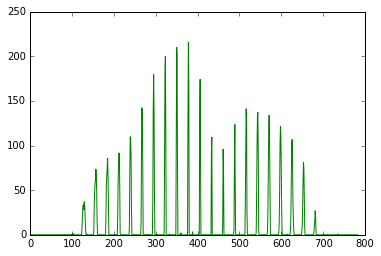

In [38]:
mean_0, mean_1  = np.zeros([784]), np.zeros([784])
for i,l in enumerate(labels_d):
    if l == 0:
        mean_0 += X_org[i]
    if l == 1:
        mean_1 += X_org[i]
mean_0, mean_1 = mean_0/200.0, mean_1/200.0

delta = mean_1 - mean_0
Delta = []
for i,d in enumerate(delta):
    if d > 0:
        Delta.append([0,d*1.1])
    elif d == 0:
        Delta.append([0,0])
    else:
        Delta.append([0,0])
print(Delta)
plt.plot(Delta)
plt.show()

In [39]:
def f(x):
    success = 0.0
    noise = np.array(x)
    (labels, centers) = run_ward(cluster_size, X_org)
    org_label = labels[mask_idx]
    Y = get_Y(labels, sample_size, cluster_size)
    X_noisy = np.copy(X_org)
    X_noisy  = add_noise(X_noisy, noise)
    (labels_dash, centers_dash) = run_ward(cluster_size, X_noisy)
    noisy_label = labels_dash[mask_idx]
    Y_dash = get_Y(labels_dash, sample_size, cluster_size)  
    dist = get_dist(Y,Y_dash)
    if dist != 0.0:
        #return -dist + linalg.norm(noise)
        return -dist
    else:
        return 1000000.0

In [25]:
bb.search(f=f,  # given function
          box=Delta,  # range of values for each parameter (2D case)
          n=10,  # number of function calls on initial stage (global search)
          m=10,  # number of function calls on subsequent stage (local search)
          batch=4,  # number of calls that will be evaluated in parallel
          resfile='output_mnist2.csv')  # text file where results will be saved

In [40]:
#best_noise is copied over from the resfile above and is the best noise the optimization algo found
### +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -1.8835e-01, -7.4101e-01, -1.5936e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -3.2326e-01, -1.0058e+00, +1.7958e-02, +1.2449e-01, -2.2302e+00, -3.9382e+00, -1.2433e+00, +7.0994e-02, +3.2145e-01, +8.8879e-02, -1.8929e+00, -1.4707e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -5.6816e-02, -3.6384e-01, -3.9571e-02, -9.0844e-01, -2.4636e+00, -3.5755e+00, -2.2246e+00, -7.9428e-01, +2.1631e+00, +4.1103e+00, +5.9757e+00, +5.9944e+00, +4.9436e+00, +6.4378e+00, +5.8025e+00, +3.9855e+00, +1.6544e+00, +2.7321e-01, -8.4276e-01, +1.5784e-01, -1.3430e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -6.1376e-02, -1.1741e+00, -1.2200e+00, -2.0752e+00, -4.3716e+00, -5.4409e+00, -1.3089e+01, -1.8243e+01, -1.6415e+01, +4.7120e-01, +3.7976e+00, +5.5882e+00, +6.5529e+00, +6.7342e+00, +8.0051e+00, +6.9666e+00, +4.6926e+00, +1.3784e+00, -6.2574e+00, -9.7922e+00, -1.1230e+01, -6.8690e+00, -1.1952e+00, +2.5783e-02, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -1.1726e+00, -2.8701e+00, -4.2545e+00, -5.8349e+00, -8.5763e+00, -1.3309e+01, -2.9558e+01, -4.4351e+01, -3.9054e+01, -9.9464e+00, +1.2419e+00, +2.9586e+00, +3.2417e+00, +3.5910e+00, +3.8915e+00, +2.7561e+00, +1.1654e+00, -5.0126e+00, -2.1428e+01, -2.8766e+01, -2.4142e+01, -1.4986e+01, -2.9848e+00, -6.5945e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -1.3936e+00, -4.5598e+00, -1.0627e+01, -1.0673e+01, -1.6321e+01, -2.9480e+01, -5.5721e+01, -9.9936e-02, -2.1401e-01, -1.2790e-01, +1.7387e+01, +5.5318e+01, +7.8002e+01, +9.0283e+01, +8.9076e+01, +5.1169e+01, +6.7829e-01, -8.3380e-01, -1.0976e+00, -1.1205e+00, -8.2415e-01, -4.4225e-01, -1.3632e-01, -2.9918e-02, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -8.3105e-02, -4.3289e-01, -6.6022e-01, -1.0084e+00, -1.5273e+00, -2.5237e+00, -4.5661e+00, -5.5836e+00, -4.5028e+00, -2.6314e+00, +8.6542e+00, +6.4466e+01, +1.0175e+02, +9.9822e+01, +8.1488e+01, +2.8058e+01, -3.4609e+00, -6.2222e+00, -5.3466e+00, -3.9384e+00, -2.3672e+00, -5.9088e-01, -3.0119e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +3.9958e-01, +0.0000e+00, -1.9062e-01, -9.5440e-01, -1.6414e+00, -2.8387e+00, -4.0550e+00, -7.1213e+00, -1.1612e+01, -1.2478e+01, -1.0411e+01, -6.5987e+00, +1.3457e+01, +8.8325e+01, +1.2339e+02, +1.0929e+02, +6.3781e+01, -9.9243e-01, -1.1065e+01, -1.3797e+01, -9.5702e+00, -5.9292e+00, -2.2461e+00, -6.4236e-01, -2.4545e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +6.1326e-01, +0.0000e+00, -2.8810e-01, -1.4289e+00, -2.8396e+00, -5.2600e+00, -8.2944e+00, -1.4652e+01, -2.0105e+01, -2.1545e+01, -1.8575e+01, -8.7021e+00, +3.2017e+01, +1.1442e+02, +1.4544e+02, +1.1103e+02, +3.3702e+01, -1.1198e+01, -2.4388e+01, -2.0658e+01, -1.0884e+01, -5.6126e+00, -1.3116e+00, -3.9712e-01, +1.4760e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -4.5341e-01, -2.0934e+00, -4.4962e+00, -8.3961e+00, -1.5766e+01, -2.3869e+01, -3.0741e+01, -3.1122e+01, -2.3420e+01, -6.0165e+00, +5.8980e+01, +1.3527e+02, +1.5036e+02, +8.8766e+01, -2.3602e+00, -2.8466e+01, -3.6290e+01, -2.3768e+01, -1.0344e+01, -5.3658e+00, -1.0923e+00, -1.4994e-01, +6.2115e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -6.2638e-01, -2.8440e+00, -6.9965e+00, -1.3934e+01, -2.6428e+01, -3.5547e+01, -4.4063e+01, -3.8689e+01, -2.5365e+01, -2.1737e+00, +7.5838e+01, +1.4707e+02, +1.4133e+02, +5.1760e+01, -2.3577e+01, -4.6477e+01, -4.1812e+01, -2.2995e+01, -1.0320e+01, -4.3476e+00, -1.5535e-01, +1.4002e+00, +2.0906e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -5.1791e-01, -4.1818e+00, -1.0277e+01, -2.0923e+01, -3.6778e+01, -4.8729e+01, -5.5108e+01, -4.6721e+01, -2.8519e+01, -1.5107e+00, +8.8689e+01, +1.3937e+02, +1.0881e+02, -3.2717e+00, -5.6586e+01, -5.9904e+01, -4.3739e+01, -2.5609e+01, -1.3467e+01, -6.4283e+00, -4.0573e-01, +2.0670e+00, +2.7868e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -7.8489e-01, -5.3183e+00, -1.4115e+01, -2.9426e+01, -4.9371e+01, -6.3431e+01, -6.6696e+01, -6.0284e+01, -4.3247e+01, -8.5527e+00, +7.6241e+01, +1.0336e+02, +5.4330e+01, -4.2391e+01, -7.9237e+01, -6.6161e+01, -4.7761e+01, -2.8805e+01, -1.4822e+01, -7.3892e+00, -1.2788e+00, -9.8075e-02, +1.2304e-01, +7.8618e-02, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -1.0079e+00, -5.6088e+00, -1.5346e+01, -3.5676e+01, -6.0323e+01, -7.6270e+01, -8.1153e+01, -7.6932e+01, -5.7952e+01, -1.1868e+01, +5.0242e+01, +5.9373e+01, +4.9680e-01, -7.1668e+01, -8.7399e+01, -7.4620e+01, -5.4313e+01, -3.4621e+01, -1.8389e+01, -1.0486e+01, -4.6876e+00, -1.1214e+00, +4.6018e-02, +2.8663e-02, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -2.2803e-01, -4.7118e+00, -1.5981e+01, -3.5888e+01, -6.0262e+01, -7.8055e+01, -8.3711e+01, -7.6666e+01, -4.2967e+01, +5.0880e+00, +4.7335e+01, +3.5694e+01, -2.8781e+01, -8.7596e+01, -9.6596e+01, -8.3667e+01, -5.7539e+01, -3.6579e+01, -1.9664e+01, -1.2853e+01, -4.6974e+00, -2.3753e+00, -3.4170e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -2.4324e+00, -1.2213e+01, -2.5321e+01, -4.5512e+01, -5.4829e+01, -5.4813e+01, -3.4238e+01, +2.8785e+00, +3.6593e+01, +5.5064e+01, +2.1423e+01, -4.8744e+01, -8.6894e+01, -9.0685e+01, -7.1309e+01, -4.5922e+01, -2.6566e+01, -1.4531e+01, -8.2301e+00, -3.9875e+00, -2.8144e+00, -4.2357e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -7.5818e-01, -5.6428e+00, -1.2892e+01, -2.1067e+01, -2.6515e+01, -1.6894e+01, +1.3595e+01, +3.7628e+01, +5.6446e+01, +5.0889e+01, +1.0057e+01, -4.5015e+01, -7.1715e+01, -7.1822e+01, -5.1325e+01, -3.1428e+01, -1.7791e+01, -1.1391e+01, -6.0180e+00, -2.4252e+00, -8.5947e-01, +0.0000e+00, +0.0000e+00, +2.3095e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -9.4053e-02, -2.6159e+00, -4.8357e+00, -6.1611e+00, +9.2680e-01, +1.5106e+01, +3.4978e+01, +4.7167e+01, +4.8414e+01, +2.9992e+01, +1.6219e+00, -3.3595e+01, -5.9558e+01, -5.8655e+01, -4.5684e+01, -2.6615e+01, -1.6872e+01, -1.0531e+01, -4.7463e+00, -1.6518e+00, -9.2314e-01, +0.0000e+00, +0.0000e+00, +8.6882e-02, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -2.9197e-01, -5.4779e-01, +1.0313e+00, +8.2746e+00, +2.4573e+01, +3.7002e+01, +4.1479e+01, +3.1592e+01, +1.4007e+01, -2.1367e+00, -2.4608e+01, -4.4094e+01, -5.1746e+01, -4.2305e+01, -2.6684e+01, -1.7352e+01, -1.1573e+01, -5.6011e+00, -2.2431e+00, -9.8526e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +8.3305e-01, +3.5762e+00, +1.2944e+01, +2.7330e+01, +3.2474e+01, +2.9614e+01, +1.6784e+01, +6.5436e+00, -1.8293e-01, -1.5475e+01, -2.9399e+01, -4.4338e+01, -4.0192e+01, -2.6121e+01, -1.8058e+01, -1.2255e+01, -5.6129e+00, -2.5927e+00, -1.0458e+00, +0.0000e+00, +1.8660e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +3.2354e-01, +1.4957e+00, +5.2528e+00, +1.4194e+01, +2.3399e+01, +2.3892e+01, +1.7480e+01, +7.7872e+00, +2.8140e+00, +8.5202e-01, -8.7321e+00, -1.8431e+01, -3.8858e+01, -3.6176e+01, -2.4422e+01, -1.5849e+01, -1.0054e+01, -5.1195e+00, -3.0198e+00, -1.1050e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +6.6103e-02, +6.8188e-01, +1.9355e+00, +5.6499e+00, +1.1298e+01, +1.4891e+01, +1.3369e+01, +7.6259e+00, +1.3900e+00, -7.5738e+00, -5.2713e+00, -8.3549e+00, -1.8013e+01, -3.6907e+01, -3.1713e+01, -2.2601e+01, -1.3730e+01, -7.1732e+00, -3.6228e+00, -3.4081e+00, -2.7220e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +1.3920e-01, +5.8113e-01, +1.5449e+00, +2.2839e+00, +3.8265e+00, +2.8671e+00, +1.5552e-01, -1.0816e+01, -2.5830e+01, -2.2347e+01, -1.2048e+01, -2.2704e+01, -2.8675e+01, -2.3718e+01, -1.2584e+01, -8.0778e+00, -3.2297e+00, -1.9863e+00, -1.8254e+00, -1.0641e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, -5.4068e-02, +0.0000e+00, -6.4102e-01, +2.8066e-02, +9.4102e-03, -1.0008e+00, -2.9127e+00, -8.1554e+00, -9.3229e+00, -4.3721e+00, -6.4010e+00, -7.5011e+00, -4.6378e+00, -3.2304e+00, -2.6727e+00, -7.7990e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +6.1528e-02, +3.7715e-02, +0.0000e+00, +0.0000e+00, +0.0000e+00, -4.0956e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, -9.6469e-01, -1.1175e+00, -1.0459e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00]
best_noise = [+0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +6.5736e-02, +4.5731e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +2.6465e-01, +1.2029e+00, +3.3388e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +8.9175e+00, +1.7040e+01, +2.4914e+01, +2.5137e+01, +2.0854e+01, +2.7321e+01, +2.4778e+01, +1.7126e+01, +7.1547e+00, +1.1893e+00, +0.0000e+00, +6.9646e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +2.4011e+00, +1.9557e+01, +2.9092e+01, +3.4496e+01, +3.5860e+01, +4.3133e+01, +3.7997e+01, +2.5917e+01, +7.7115e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +1.5733e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +1.0512e+01, +2.5827e+01, +2.9236e+01, +3.3521e+01, +3.7678e+01, +2.7742e+01, +1.2225e+01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +5.5137e+00, +1.7294e+01, +2.4034e+01, +2.7411e+01, +2.6640e+01, +1.5071e+01, +1.9668e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +1.6031e+00, +1.1622e+01, +1.7836e+01, +1.6999e+01, +1.3467e+01, +4.4957e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +4.1361e-02, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +5.2270e-01, +2.9426e+00, +3.4263e+00, +2.4258e+00, +1.0590e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +6.9944e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +3.5358e+01, +1.2600e+02, +1.5972e+02, +1.2159e+02, +3.6801e+01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +1.5740e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +5.9724e+01, +1.3651e+02, +1.5120e+02, +8.8953e+01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +6.0236e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +6.8925e+01, +1.3308e+02, +1.2733e+02, +4.6424e+01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +1.2102e+00, +1.7982e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +7.0117e+01, +1.0955e+02, +8.5035e+01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +1.5286e+00, +2.0475e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +4.9911e+01, +6.7125e+01, +3.4997e+01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +7.2588e-02, +4.5943e-02, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +2.4959e+01, +2.9132e+01, +2.4071e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +1.9375e-02, +1.1880e-02, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +1.6201e+00, +1.4732e+01, +1.0851e+01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +3.0898e-01, +3.6146e+00, +4.9644e+00, +1.7454e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +3.1721e+01, +8.7798e+01, +1.3171e+02, +1.1874e+02, +2.3467e+01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +5.3887e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +2.1625e+00, +3.5248e+01, +8.1615e+01, +1.1006e+02, +1.1297e+02, +6.9982e+01, +3.7844e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +2.0272e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +2.4064e+00, +1.9307e+01, +5.7338e+01, +8.6338e+01, +9.6784e+01, +7.3716e+01, +3.2683e+01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +1.9438e+00, +8.3446e+00, +3.0203e+01, +6.3771e+01, +7.5773e+01, +6.9100e+01, +3.9162e+01, +1.5269e+01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +4.3540e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +7.5492e-01, +3.4899e+00, +1.2257e+01, +3.3118e+01, +5.4599e+01, +5.5747e+01, +4.0787e+01, +1.8170e+01, +6.5660e+00, +1.9880e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +1.5424e-01, +1.5911e+00, +4.5163e+00, +1.3183e+01, +2.6362e+01, +3.4746e+01, +3.1195e+01, +1.7794e+01, +3.2434e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +3.2479e-01, +1.3560e+00, +3.6049e+00, +5.3292e+00, +8.9284e+00, +6.6899e+00, +3.6287e-01, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +6.5488e-02, +2.1957e-02, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +1.4357e-01, +8.8002e-02, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00, +0.0000e+00]
np.save('wip_MNIST_X_org.npy', X_org)
np.savetxt('X_org.csv', X_org, delimiter=',')
X_adv = np.copy(X_org)
X_adv = add_noise(X_adv, best_noise)
np.save('wip_MNIST_X_adv.npy', X_adv)
np.savetxt('X_adv.csv', X_adv, delimiter=',')
print(mask_idx)

384


In [41]:
Xo = np.load('wip_MNIST_X_org.npy')
Xa = np.load('wip_MNIST_X_adv.npy')

lo,_ = run_ward(2, Xo)
la,_ = run_ward(2, Xa)

In [42]:
print(lo[mask_idx],la[mask_idx])
np.savetxt('lo.csv', lo, delimiter=',')
np.savetxt('la.csv', la, delimiter=',')

(0, 1)


In [43]:
count_diffs = 0
perturbed_idx = []
for idx,(el1, el2) in enumerate(zip(lo,la)):
    if el1 != el2:
        count_diffs += 1
        perturbed_idx.append(idx)
print(count_diffs)

11


5


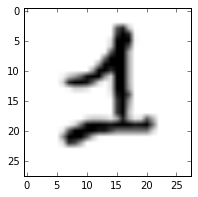

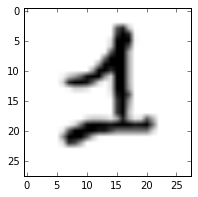

31


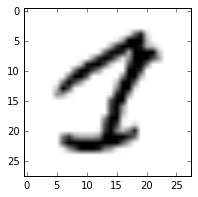

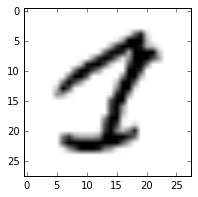

72


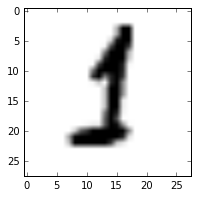

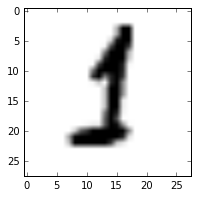

137


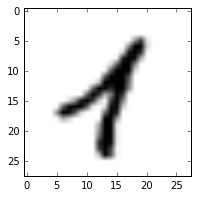

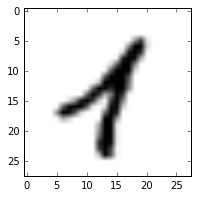

216


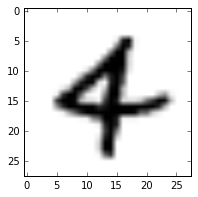

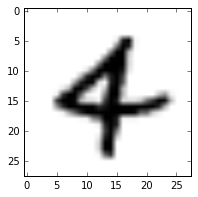

229


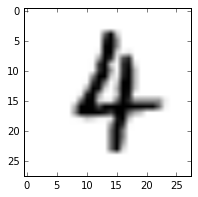

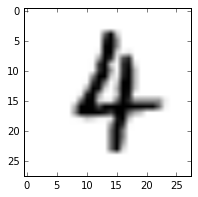

277


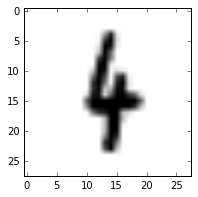

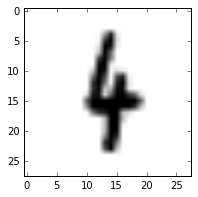

318


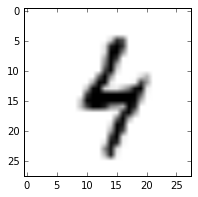

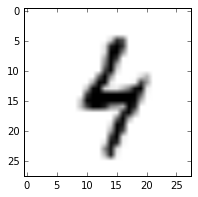

366


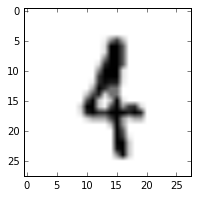

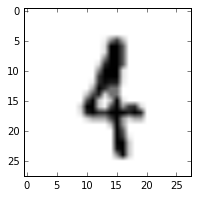

384


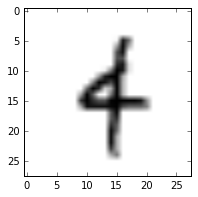

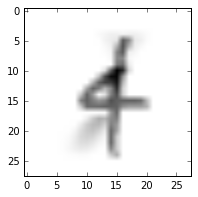

394


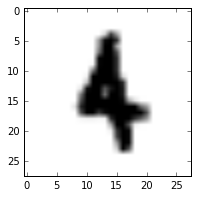

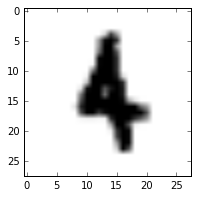

In [44]:
for idx, (org,noisy) in enumerate(zip(Xo, Xa)):
    if idx in perturbed_idx or idx == mask_idx:
        print(idx)
        plt.figure(1,figsize=(3,3)) ##
        plt.imshow(np.reshape(org,(28,28)), cmap=plt.cm.gray_r) ##
        plt.show() ##
        plt.figure(1,figsize=(3,3)) ##
        plt.imshow(np.reshape(noisy,(28,28)), cmap=plt.cm.gray_r) ##
        plt.show() ##

In [31]:
for i in perturbed_idx:
    print(lo[i], la[i], y[i])

(0, 1, 2)
(0, 1, 8)
(0, 1, 1)
(0, 1, 8)
(0, 1, 0)
(0, 1, 0)
(0, 1, 2)
(0, 1, 2)
(0, 1, 1)
(0, 1, 7)
(0, 1, 1)


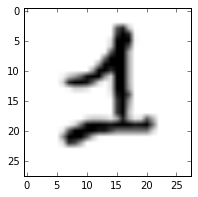

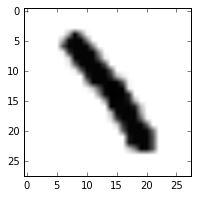

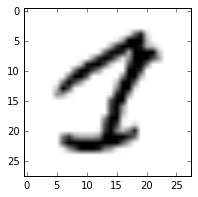

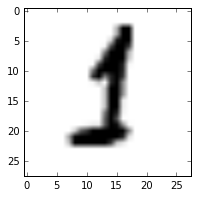

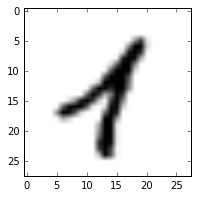

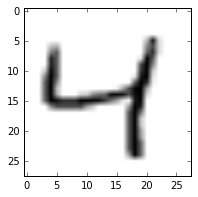

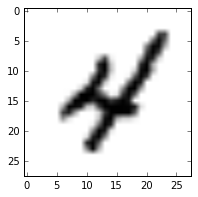

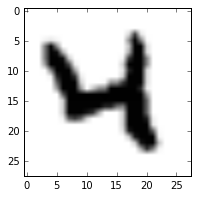

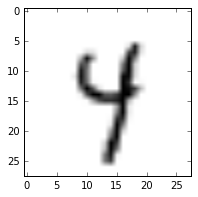

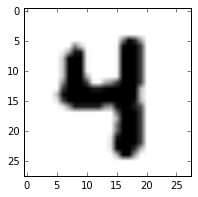

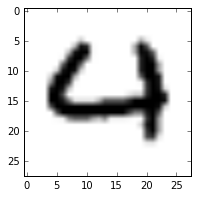

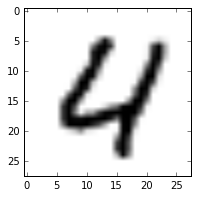

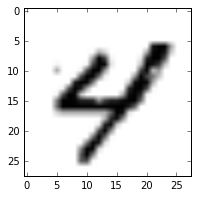

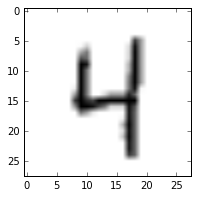

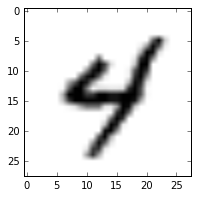

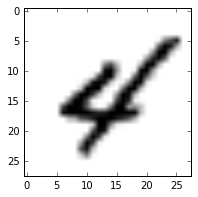

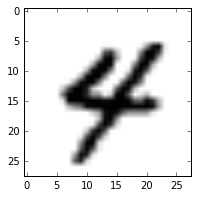

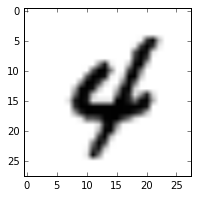

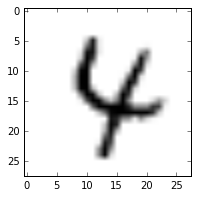

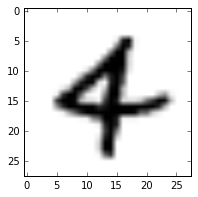

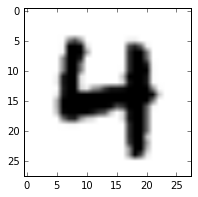

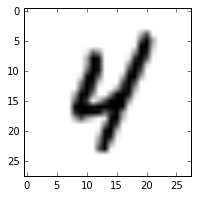

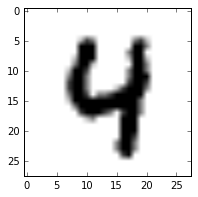

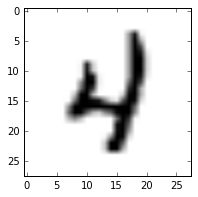

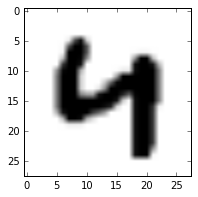

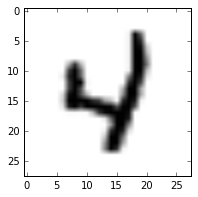

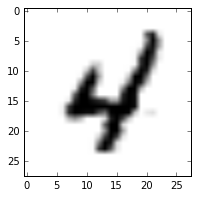

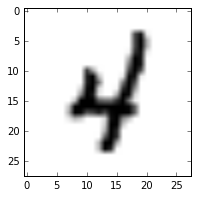

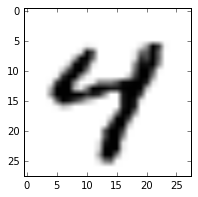

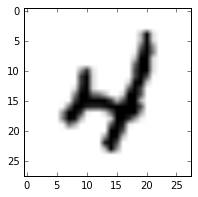

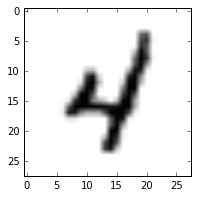

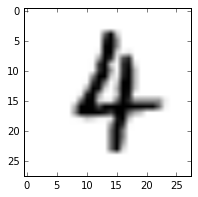

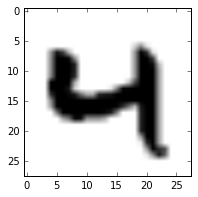

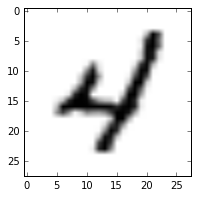

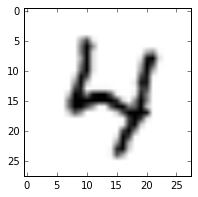

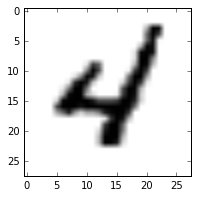

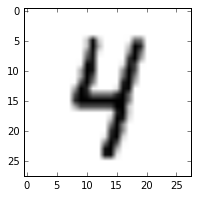

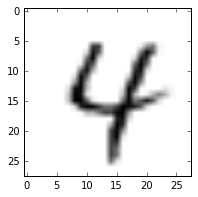

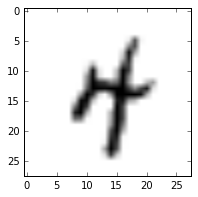

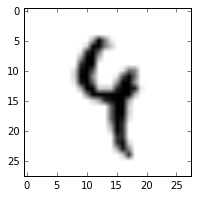

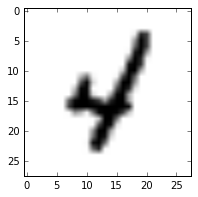

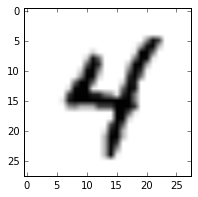

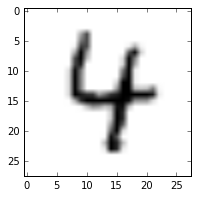

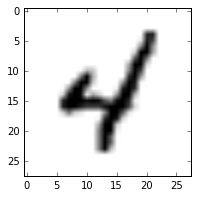

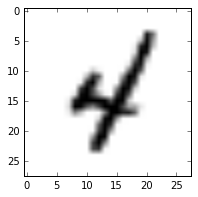

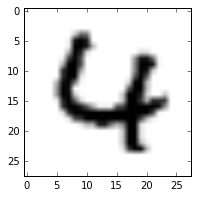

KeyboardInterrupt: 

In [15]:
for i,l in enumerate(lo):
    if l == 0:
        plt.figure(1,figsize=(3,3)) ##
        plt.imshow(np.reshape(Xo[i,:],(28,28)), cmap=plt.cm.gray_r) ##
        plt.show() ##